In [1]:
import matplotlib.pyplot as plt
import torch

import numpy as np

from random import shuffle
from tqdm import tqdm

from qiskit.visualization import plot_histogram

In [2]:
import sys

import sys
sys.path.append('../')

In [3]:
from circuits.generate_circuits import generate_random_circuit
from circuits.modify_circuits import get_param_circuit_for_model, get_str_circuit_for_model, append_pqc_to_quantum_circuit
from circuits.pqc_circuits import qiskit_PQC_RZRXRZ_unique, pennylane_PQC_RZRXRZ_unique

from simulator.simulate import run_sampler_pennylane, run_state_pennylane, get_ideal_data_state

from models.pennylane_models import SimplePennylaneQuantumStateModel
from models.noise_models import BitPhaseFlipNoise

from utils.loss_functions import QuantumFidelityLoss

In [4]:
NUM_QUBITS = 5
NUM_GATES = 10
NUM_VALS = 5000
EPOCHS = 3

In [5]:
noise_model = BitPhaseFlipNoise()

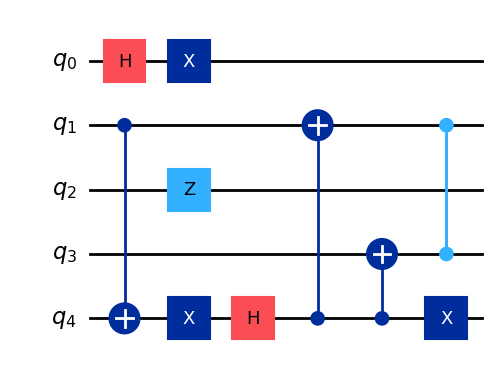

In [6]:
circuit = generate_random_circuit(NUM_QUBITS, NUM_GATES, seed=42)
circuit.draw('mpl')

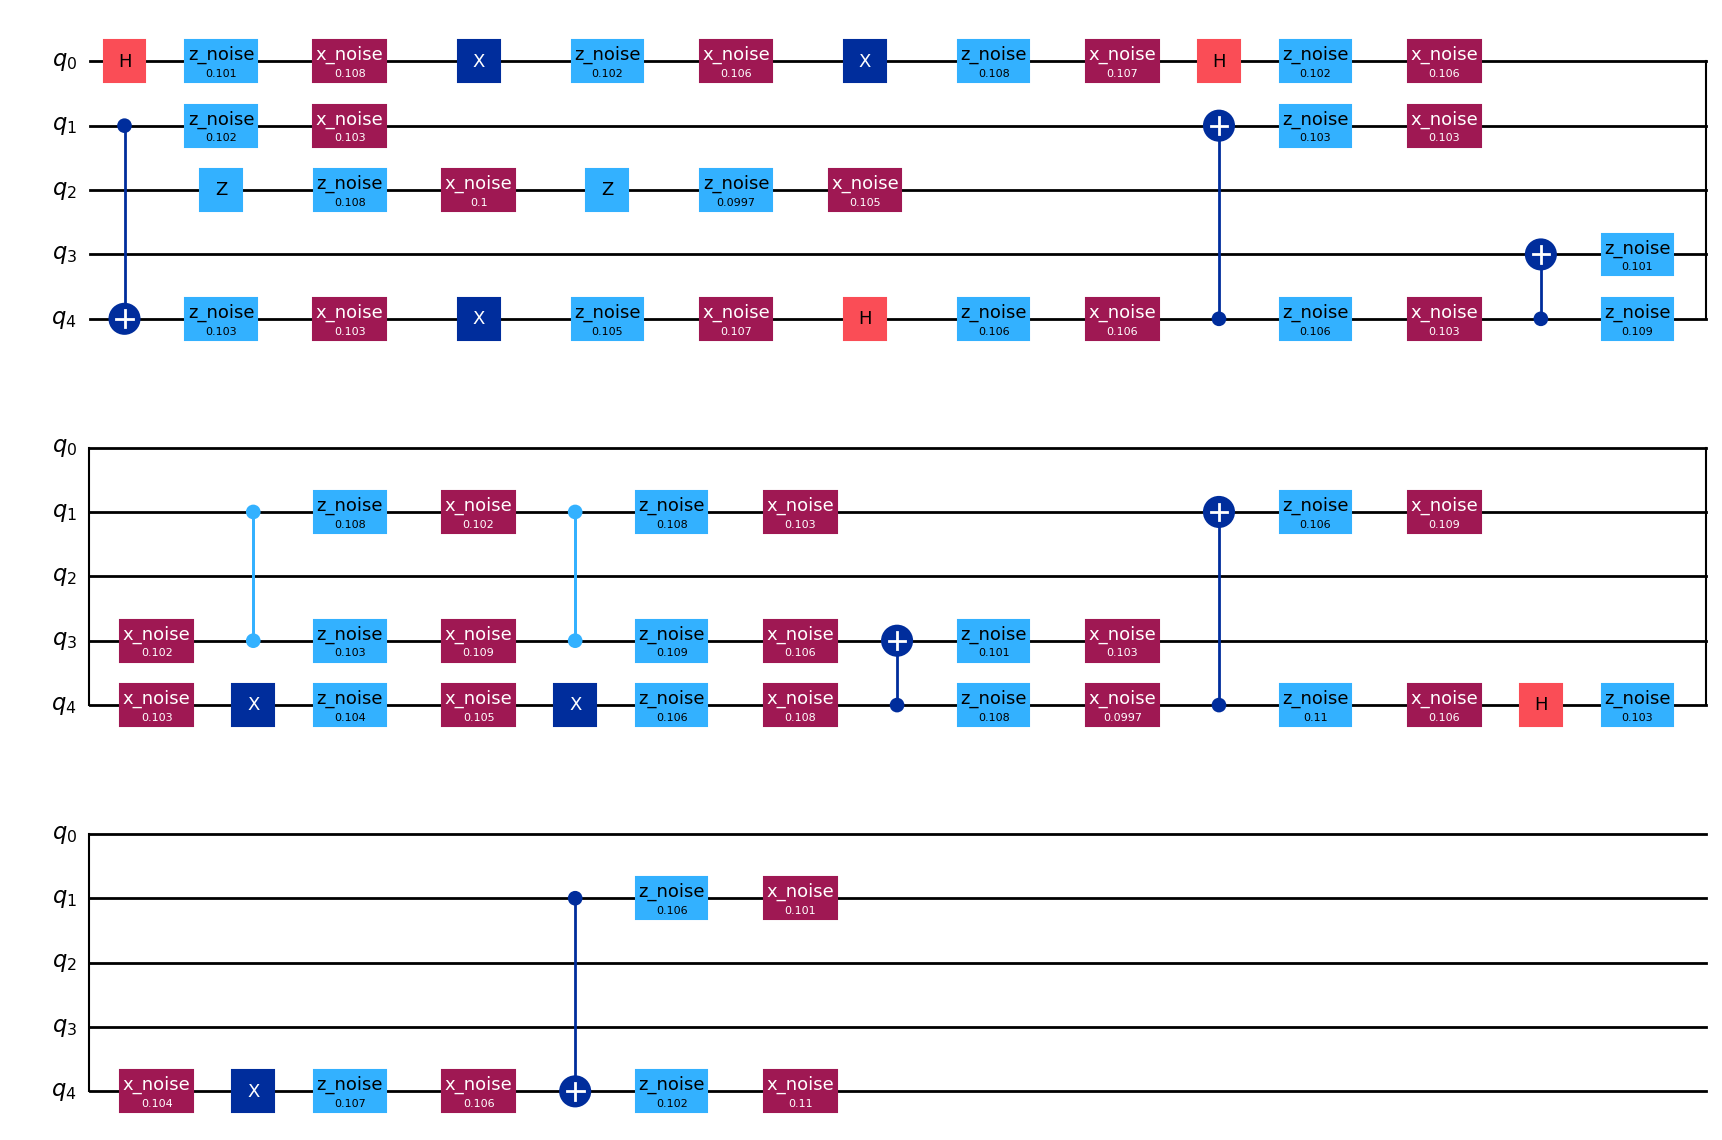

In [7]:
noisy_circ = noise_model.get_noisy_circuit_for_model(circuit)

noisy_circ.draw('mpl')

In [8]:
ideal_data = get_ideal_data_state(NUM_QUBITS, NUM_VALS)

Generating Ideal Data: 100%|██████████| 5000/5000 [00:02<00:00, 2242.58it/s]


In [9]:
pqc_model = SimplePennylaneQuantumStateModel(num_qubits=NUM_QUBITS, num_params=3*NUM_QUBITS, pqc_arch_func=pennylane_PQC_RZRXRZ_unique)
optimizer = torch.optim.AdamW(params=pqc_model.parameters(), lr=0.05)
loss_fn = QuantumFidelityLoss()

In [10]:
param_list = []  # Stores parameter evolution across epochs
loss_list_epoch = []   # Stores mean loss per epoch

enable_debug_logs = True  # Set False to suppress grad/param printouts
lambda_reg = 0.01         # Regularization weight

for epoch in range(EPOCHS):
    print(f'\n Starting Epoch {epoch+1}')
    pqc_model.train()
    epoch_loss_list = []

    shuffle(ideal_data)
    data_iterator = tqdm(ideal_data)

    for step, (params, ideal) in enumerate(data_iterator):
        optimizer.zero_grad()

        model_circuit = get_param_circuit_for_model(params, noise_model.get_noisy_circuit_for_model(circuit))
        measured = pqc_model(circuit=model_circuit)

        loss = loss_fn(ideal, measured)

        # Add optional regularization to keep angles from zeroing out

        loss.backward()
        optimizer.step()

        raw_param_values = pqc_model.raw_params.detach().cpu().numpy()
        param_list.append(raw_param_values)
        epoch_loss_list.append(loss.item())

        data_iterator.set_postfix_str(f"Loss: {loss.item():.4e}")

        # Optional: print debug stats
        if enable_debug_logs and step == 0:
            grad_norm = pqc_model.raw_params.grad.norm().item()
            # bounded = pqc_model.raw_params.detach().cpu().numpy()
            print(f"\tStep {step}, grad norm: {grad_norm:.4e}")
            print(f"\tRaw param range: [{raw_param_values.min():.3f}, {raw_param_values.max():.3f}]")
            # print(f"\tBounded param range: [{bounded.min():.3f}, {bounded.max():.3f}]")


    # Log epoch summary
    avg_loss = np.mean(epoch_loss_list)
    loss_list_epoch.append(avg_loss)

    print(f"Epoch {epoch+1} complete: avg loss = {avg_loss:.4e}")

        


 Starting Epoch 1


  0%|          | 16/5000 [00:00<00:31, 157.36it/s, Loss: 3.6631e-01]

	Step 0, grad norm: 1.2842e-02
	Raw param range: [-5.938, 10.956]


100%|██████████| 5000/5000 [00:27<00:00, 178.75it/s, Loss: 9.3990e-02]


Epoch 1 complete: avg loss = 1.3813e-01

 Starting Epoch 2


  0%|          | 17/5000 [00:00<00:30, 163.36it/s, Loss: 1.1137e-01]

	Step 0, grad norm: 2.5373e-01
	Raw param range: [-6.475, 9.366]


100%|██████████| 5000/5000 [00:28<00:00, 177.91it/s, Loss: 1.5684e-01]


Epoch 2 complete: avg loss = 1.3163e-01

 Starting Epoch 3


  0%|          | 18/5000 [00:00<00:28, 172.13it/s, Loss: 1.5034e-01]

	Step 0, grad norm: 1.6676e-01
	Raw param range: [-6.475, 9.442]


100%|██████████| 5000/5000 [00:30<00:00, 165.17it/s, Loss: 1.0434e-01]

Epoch 3 complete: avg loss = 1.3167e-01


Generating Ideal Data: 100%|██████████| 20/20 [00:00<00:00, 1563.84it/s]


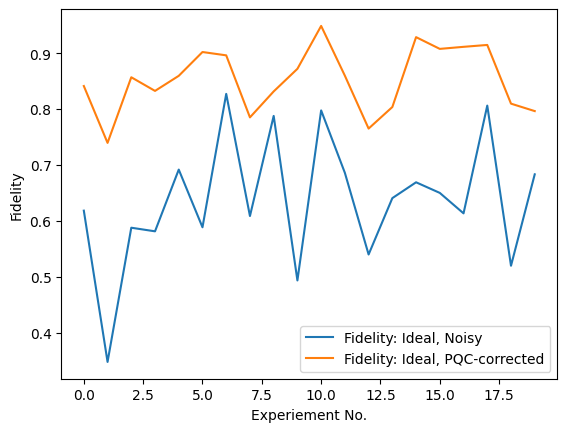

Avg Fidelity of noisy circuit: 0.6369293566315529, Average Fidelity of noisy circ with PQC: 0.8530644093920662


In [11]:
from qiskit.quantum_info import Statevector

def state_fidelity(psi: torch.Tensor, phi: torch.Tensor) -> torch.Tensor:
    """
    Compute fidelity F = |⟨ψ|φ⟩|² between two normalized state vectors.

    Args:
        psi (torch.Tensor): Complex tensor of shape (2**n,) representing |ψ⟩
        phi (torch.Tensor): Complex tensor of shape (2**n,) representing |φ⟩

    Returns:
        torch.Tensor: Real-valued scalar fidelity
    """
    # Optional: normalize if needed
    psi = psi / torch.linalg.norm(psi)
    phi = phi / torch.linalg.norm(phi)

    overlap = torch.dot(torch.conj(psi), phi)
    return torch.abs(overlap) ** 2

fid_noisy = []
fid_noisy_pqc = []

pqc_params = pqc_model.raw_params

ideal_data_test = get_ideal_data_state(NUM_QUBITS, num_vals=20)
pqc_model.eval()

for param, ideal in ideal_data_test:
    noisy_circ = get_param_circuit_for_model(param, noise_model.get_noisy_circuit_for_model(circuit=circuit))
    # noisy_circ_pqc = append_pqc_to_quantum_circuit(noisy_circ, pqc_params, qiskit_PQC_RZRXRZ_unique)

    noi_out_st = run_state_pennylane(noisy_circ)
    npqc_out_st = pqc_model(noisy_circ)
    
    

    fid_i_n = state_fidelity(ideal, noi_out_st)
    fid_i_ne = state_fidelity(ideal, npqc_out_st.detach())

    fid_noisy.append(fid_i_n)
    fid_noisy_pqc.append(fid_i_ne)

x = range(len(ideal_data_test))

# option 1 ─ two explicit calls
plt.plot(x, fid_noisy,      label='Fidelity: Ideal, Noisy')
plt.plot(x, fid_noisy_pqc,  label='Fidelity: Ideal, PQC-corrected')
plt.xlabel('Experiement No.')          # optional cosmetics
plt.ylabel('Fidelity')
plt.legend()                      # shows the two labels
plt.show()

print(f"Avg Fidelity of noisy circuit: {np.mean(fid_noisy)}, Average Fidelity of noisy circ with PQC: {np.mean(fid_noisy_pqc)}")

In [12]:
pqc_model.raw_params

Parameter containing:
tensor([ 6.0558,  6.0727, -6.4684,  0.1166,  0.0191, -0.2665, -0.0817,  6.2945,
        -0.1294,  9.1457,  0.2408, -2.9607, -3.2146,  7.2257,  9.4167],
       requires_grad=True)

In [13]:
INPUT_BITS = '11001'
str_noisy_circ = get_str_circuit_for_model(INPUT_BITS, noise_model.get_noisy_circuit_for_model(circuit))
str_noisy_circ_pqc = append_pqc_to_quantum_circuit(str_noisy_circ, pqc_model.raw_params, qiskit_PQC_RZRXRZ_unique)

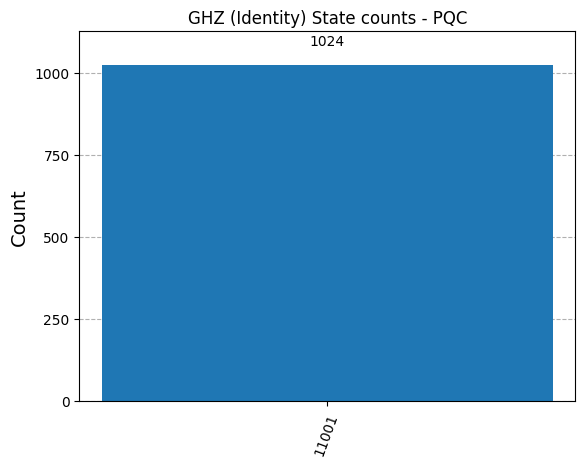

In [14]:
counts = run_sampler_pennylane(str_noisy_circ)

plot_histogram(counts, title='GHZ (Identity) State counts - PQC')

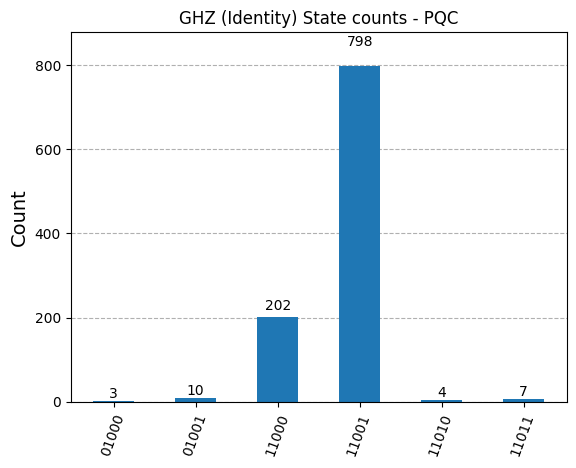

In [15]:
counts = run_sampler_pennylane(str_noisy_circ_pqc)

plot_histogram(counts, title='GHZ (Identity) State counts - PQC')